In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('data/raw/telco_customer_churn.csv')

In [5]:
# Проверка текущего типа TotalCharges
print("Тип данных TotalCharges до преобразования:")
print(df['TotalCharges'].dtype)
print(f"\nПример значений:\n{df['TotalCharges'].head(10)}")

# Преобразование в float (пустые строки станут NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')


print(f"\nТипz данных TotalCharges после преобразования:")
print(df['TotalCharges'].dtype)
print(f"\nСтатистика TotalCharges:")
print(df['TotalCharges'].describe())

Тип данных TotalCharges до преобразования:
object

Пример значений:
0      29.85
1     1889.5
2     108.15
3    1840.75
4     151.65
5      820.5
6     1949.4
7      301.9
8    3046.05
9    3487.95
Name: TotalCharges, dtype: object

Типz данных TotalCharges после преобразования:
float64

Статистика TotalCharges:
count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# Feature Engineering

Создадим две выборки:
1. **Базовая выборка** - исходные данные с минимальной обработкой
2. **Расширенная выборка** - с композитными признаками и группировкой категорий

In [26]:
# Обзор уникальных значений для понимания данных
print("=== Обзор категориальных признаков ===\n")

categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    if col != 'customerID':
        print(f"{col}: {df[col].unique()}")
        print(f"Количество уникальных значений: {df[col].nunique()}\n")

=== Обзор категориальных признаков ===

gender: ['Female' 'Male']
Количество уникальных значений: 2

Partner: ['Yes' 'No']
Количество уникальных значений: 2

Dependents: ['No' 'Yes']
Количество уникальных значений: 2

PhoneService: ['No' 'Yes']
Количество уникальных значений: 2

MultipleLines: ['No phone service' 'No' 'Yes']
Количество уникальных значений: 3

InternetService: ['DSL' 'Fiber optic' 'No']
Количество уникальных значений: 3

OnlineSecurity: ['No' 'Yes' 'No internet service']
Количество уникальных значений: 3

OnlineBackup: ['Yes' 'No' 'No internet service']
Количество уникальных значений: 3

DeviceProtection: ['No' 'Yes' 'No internet service']
Количество уникальных значений: 3

TechSupport: ['No' 'Yes' 'No internet service']
Количество уникальных значений: 3

StreamingTV: ['No' 'Yes' 'No internet service']
Количество уникальных значений: 3

StreamingMovies: ['No' 'Yes' 'No internet service']
Количество уникальных значений: 3

Contract: ['Month-to-month' 'One year' 'Two year

## 1. Базовая выборка

Подготовим базовую выборку с минимальной обработкой:
- Заполним пропуски в `TotalCharges`
- Удалим `customerID`

In [6]:
# Создание базовой выборки
df_base = df.copy()

# Заполнение пропусков в TotalCharges медианным значением
df_base['TotalCharges'].fillna(df_base['TotalCharges'].median(), inplace=True)

# Удаление customerID
df_base = df_base.drop('customerID', axis=1)

print("=== Базовая выборка ===")
print(f"Размер: {df_base.shape}")
print(f"\nПропуски:\n{df_base.isnull().sum().sum()}")
print(f"\nПризнаки:\n{df_base.columns.tolist()}")

=== Базовая выборка ===
Размер: (7043, 20)

Пропуски:
0

Признаки:
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


/var/folders/_q/jch9fljj5nl58d8m44_f5f1c0000gn/T/ipykernel_5882/3963861878.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_base['TotalCharges'].fillna(df_base['TotalCharges'].median(), inplace=True)


## 2. Расширенная выборка с новыми признаками

Создадим композитные признаки и сгруппируем категории:

In [7]:
# Создание расширенной выборки
df_enhanced = df.copy()

# Заполнение пропусков в TotalCharges
df_enhanced['TotalCharges'].fillna(df_enhanced['TotalCharges'].median(), inplace=True)

# Удаление customerID
df_enhanced = df_enhanced.drop('customerID', axis=1)

print("=== Создание композитных признаков ===\n")

# 1. total_services - количество подключенных дополнительных сервисов
internet_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                     'TechSupport', 'StreamingTV', 'StreamingMovies']

df_enhanced['total_services'] = 0
for service in internet_services:
    df_enhanced['total_services'] += (df_enhanced[service] == 'Yes').astype(int)

# Добавляем PhoneService и MultipleLines
df_enhanced['total_services'] += (df_enhanced['PhoneService'] == 'Yes').astype(int)
df_enhanced['total_services'] += (df_enhanced['MultipleLines'] == 'Yes').astype(int)

print(f"1. total_services создан")
print(f"   Диапазон: {df_enhanced['total_services'].min()} - {df_enhanced['total_services'].max()}")
print(f"   Среднее: {df_enhanced['total_services'].mean():.2f}\n")

# 2. has_automatic_payment - автоматическая оплата
df_enhanced['has_automatic_payment'] = df_enhanced['PaymentMethod'].isin(
    ['Bank transfer (automatic)', 'Credit card (automatic)']
).astype(int)

print(f"2. has_automatic_payment создан")
print(f"   Распределение:\n{df_enhanced['has_automatic_payment'].value_counts()}\n")

# 3. is_new_customer - новый клиент (tenure < 12 месяцев)
df_enhanced['is_new_customer'] = (df_enhanced['tenure'] < 12).astype(int)

print(f"3. is_new_customer создан")
print(f"   Распределение:\n{df_enhanced['is_new_customer'].value_counts()}\n")

# 4. has_protection_services - есть защитные сервисы
df_enhanced['has_protection_services'] = (
    (df_enhanced['OnlineSecurity'] == 'Yes') | 
    (df_enhanced['TechSupport'] == 'Yes')
).astype(int)

print(f"4. has_protection_services создан")
print(f"   Распределение:\n{df_enhanced['has_protection_services'].value_counts()}\n")

# 5. charge_per_month_tenure - стоимость на месяц стажа
df_enhanced['charge_per_month_tenure'] = df_enhanced['MonthlyCharges'] / (df_enhanced['tenure'] + 1)

print(f"5. charge_per_month_tenure создан")
print(f"   Диапазон: {df_enhanced['charge_per_month_tenure'].min():.2f} - {df_enhanced['charge_per_month_tenure'].max():.2f}")
print(f"   Среднее: {df_enhanced['charge_per_month_tenure'].mean():.2f}\n")

=== Создание композитных признаков ===

1. total_services создан
   Диапазон: 0 - 8
   Среднее: 3.36

2. has_automatic_payment создан
   Распределение:
has_automatic_payment
0    3977
1    3066
Name: count, dtype: int64

3. is_new_customer создан
   Распределение:
is_new_customer
0    4974
1    2069
Name: count, dtype: int64

4. has_protection_services создан
   Распределение:
has_protection_services
0    4079
1    2964
Name: count, dtype: int64

5. charge_per_month_tenure создан
   Диапазон: 0.26 - 80.85
   Среднее: 5.77



/var/folders/_q/jch9fljj5nl58d8m44_f5f1c0000gn/T/ipykernel_5882/1150129043.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_enhanced['TotalCharges'].fillna(df_enhanced['TotalCharges'].median(), inplace=True)


In [8]:
print("=== Группировка категорий ===\n")

# 1. Объединение "No internet service" и "No" для интернет-сервисов
internet_service_features = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                             'TechSupport', 'StreamingTV', 'StreamingMovies']

for feature in internet_service_features:
    df_enhanced[feature] = df_enhanced[feature].replace('No internet service', 'No')
    
print(f"1. Интернет-сервисы: 'No internet service' -> 'No'")
print(f"   Пример OnlineSecurity: {df_enhanced['OnlineSecurity'].unique()}\n")

# 2. Разбиение tenure на категории
def categorize_tenure(tenure):
    if tenure <= 12:
        return 'new'  # новый (0-12)
    elif tenure <= 36:
        return 'medium'  # средний (13-36)
    else:
        return 'long_term'  # долгосрочный (37+)

df_enhanced['tenure_category'] = df_enhanced['tenure'].apply(categorize_tenure)

print(f"2. tenure_category создан")
print(f"   Распределение:\n{df_enhanced['tenure_category'].value_counts()}\n")

print("=== Итоговая расширенная выборка ===")
print(f"Размер: {df_enhanced.shape}")
print(f"\nНовые признаки:")
new_features = ['total_services', 'has_automatic_payment', 'is_new_customer', 
                'has_protection_services', 'charge_per_month_tenure', 'tenure_category']
print(new_features)

=== Группировка категорий ===

1. Интернет-сервисы: 'No internet service' -> 'No'
   Пример OnlineSecurity: ['No' 'Yes']

2. tenure_category создан
   Распределение:
tenure_category
long_term    3001
new          2186
medium       1856
Name: count, dtype: int64

=== Итоговая расширенная выборка ===
Размер: (7043, 26)

Новые признаки:
['total_services', 'has_automatic_payment', 'is_new_customer', 'has_protection_services', 'charge_per_month_tenure', 'tenure_category']


## 3. Сравнение выборок

In [19]:
# Сравнение выборок
print("="*60)
print("СРАВНЕНИЕ БАЗОВОЙ И РАСШИРЕННОЙ ВЫБОРОК")
print("="*60)

print("\n📊 БАЗОВАЯ ВЫБОРКА (df_base):")
print(f"   - Размерность: {df_base.shape}")
print(f"   - Количество признаков: {df_base.shape[1]}")
print(f"   - Пропуски: {df_base.isnull().sum().sum()}")

print("\n📊 РАСШИРЕННАЯ ВЫБОРКА (df_enhanced):")
print(f"   - Размерность: {df_enhanced.shape}")
print(f"   - Количество признаков: {df_enhanced.shape[1]}")
print(f"   - Пропуски: {df_enhanced.isnull().sum().sum()}")
print(f"   - Новых признаков: {df_enhanced.shape[1] - df_base.shape[1]}")

print("\n✅ НОВЫЕ ПРИЗНАКИ В РАСШИРЕННОЙ ВЫБОРКЕ:")
new_cols = set(df_enhanced.columns) - set(df_base.columns)
for i, col in enumerate(sorted(new_cols), 1):
    print(f"   {i}. {col}")

print("\n" + "="*60)

СРАВНЕНИЕ БАЗОВОЙ И РАСШИРЕННОЙ ВЫБОРОК

📊 БАЗОВАЯ ВЫБОРКА (df_base):
   - Размерность: (7043, 20)
   - Количество признаков: 20
   - Пропуски: 0

📊 РАСШИРЕННАЯ ВЫБОРКА (df_enhanced):
   - Размерность: (7043, 26)
   - Количество признаков: 26
   - Пропуски: 0
   - Новых признаков: 6

✅ НОВЫЕ ПРИЗНАКИ В РАСШИРЕННОЙ ВЫБОРКЕ:
   1. charge_per_month_tenure
   2. has_automatic_payment
   3. has_protection_services
   4. is_new_customer
   5. tenure_category
   6. total_services



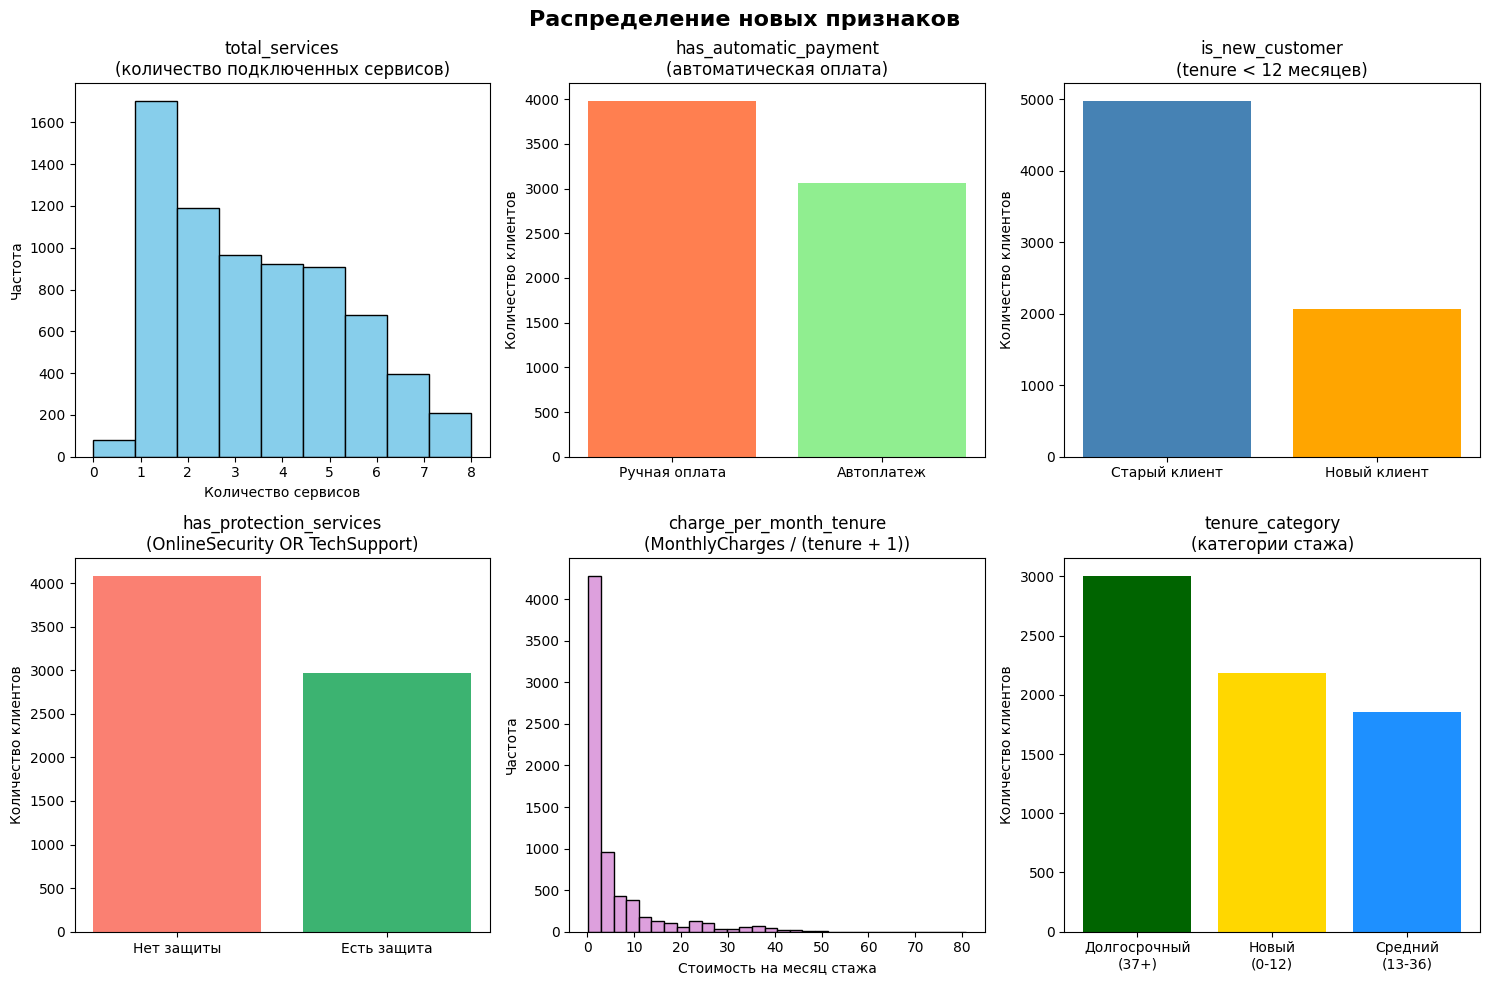

In [20]:
# Визуализация новых признаков
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Распределение новых признаков', fontsize=16, fontweight='bold')

# 1. total_services
axes[0, 0].hist(df_enhanced['total_services'], bins=9, edgecolor='black', color='skyblue')
axes[0, 0].set_title('total_services\n(количество подключенных сервисов)')
axes[0, 0].set_xlabel('Количество сервисов')
axes[0, 0].set_ylabel('Частота')

# 2. has_automatic_payment
payment_counts = df_enhanced['has_automatic_payment'].value_counts()
axes[0, 1].bar(['Ручная оплата', 'Автоплатеж'], payment_counts.values, color=['coral', 'lightgreen'])
axes[0, 1].set_title('has_automatic_payment\n(автоматическая оплата)')
axes[0, 1].set_ylabel('Количество клиентов')

# 3. is_new_customer
customer_counts = df_enhanced['is_new_customer'].value_counts()
axes[0, 2].bar(['Старый клиент', 'Новый клиент'], customer_counts.values, color=['steelblue', 'orange'])
axes[0, 2].set_title('is_new_customer\n(tenure < 12 месяцев)')
axes[0, 2].set_ylabel('Количество клиентов')

# 4. has_protection_services
protection_counts = df_enhanced['has_protection_services'].value_counts()
axes[1, 0].bar(['Нет защиты', 'Есть защита'], protection_counts.values, color=['salmon', 'mediumseagreen'])
axes[1, 0].set_title('has_protection_services\n(OnlineSecurity OR TechSupport)')
axes[1, 0].set_ylabel('Количество клиентов')

# 5. charge_per_month_tenure
axes[1, 1].hist(df_enhanced['charge_per_month_tenure'], bins=30, edgecolor='black', color='plum')
axes[1, 1].set_title('charge_per_month_tenure\n(MonthlyCharges / (tenure + 1))')
axes[1, 1].set_xlabel('Стоимость на месяц стажа')
axes[1, 1].set_ylabel('Частота')

# 6. tenure_category
tenure_cat_counts = df_enhanced['tenure_category'].value_counts()
axes[1, 2].bar(['Долгосрочный\n(37+)', 'Новый\n(0-12)', 'Средний\n(13-36)'], 
               [tenure_cat_counts['long_term'], tenure_cat_counts['new'], tenure_cat_counts['medium']],
               color=['darkgreen', 'gold', 'dodgerblue'])
axes[1, 2].set_title('tenure_category\n(категории стажа)')
axes[1, 2].set_ylabel('Количество клиентов')

plt.tight_layout()
plt.show()

In [21]:
# Детальная информация о расширенной выборке
print("=== РАСШИРЕННАЯ ВЫБОРКА: ДЕТАЛЬНАЯ ИНФОРМАЦИЯ ===\n")
df_enhanced.info()

=== РАСШИРЕННАЯ ВЫБОРКА: ДЕТАЛЬНАЯ ИНФОРМАЦИЯ ===

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gender                   7043 non-null   object 
 1   SeniorCitizen            7043 non-null   int64  
 2   Partner                  7043 non-null   object 
 3   Dependents               7043 non-null   object 
 4   tenure                   7043 non-null   int64  
 5   PhoneService             7043 non-null   object 
 6   MultipleLines            7043 non-null   object 
 7   InternetService          7043 non-null   object 
 8   OnlineSecurity           7043 non-null   object 
 9   OnlineBackup             7043 non-null   object 
 10  DeviceProtection         7043 non-null   object 
 11  TechSupport              7043 non-null   object 
 12  StreamingTV              7043 non-null   object 
 13  StreamingMovies          70

In [22]:
# Первые строки расширенной выборки
print("=== Первые 5 строк расширенной выборки ===\n")
df_enhanced.head()

=== Первые 5 строк расширенной выборки ===



,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,PaymentMethod,MonthlyCharges,TotalCharges,Churn,total_services,has_automatic_payment,is_new_customer,has_protection_services,charge_per_month_tenure,tenure_category
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,Electronic check,29.85,29.85,No,1,0,1,0,14.925000,new
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,Mailed check,56.95,1889.50,No,3,0,0,1,1.627143,medium
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,Mailed check,53.85,108.15,Yes,3,0,1,1,17.950000,new
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,Bank transfer (automatic),42.30,1840.75,No,3,1,0,1,0.919565,long_term
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,Electronic check,70.70,151.65,Yes,1,0,1,0,23.566667,new


## 3.1. Анализ новых признаков по целевой переменной Churn

Посмотрим как новые признаки связаны с оттоком клиентов:

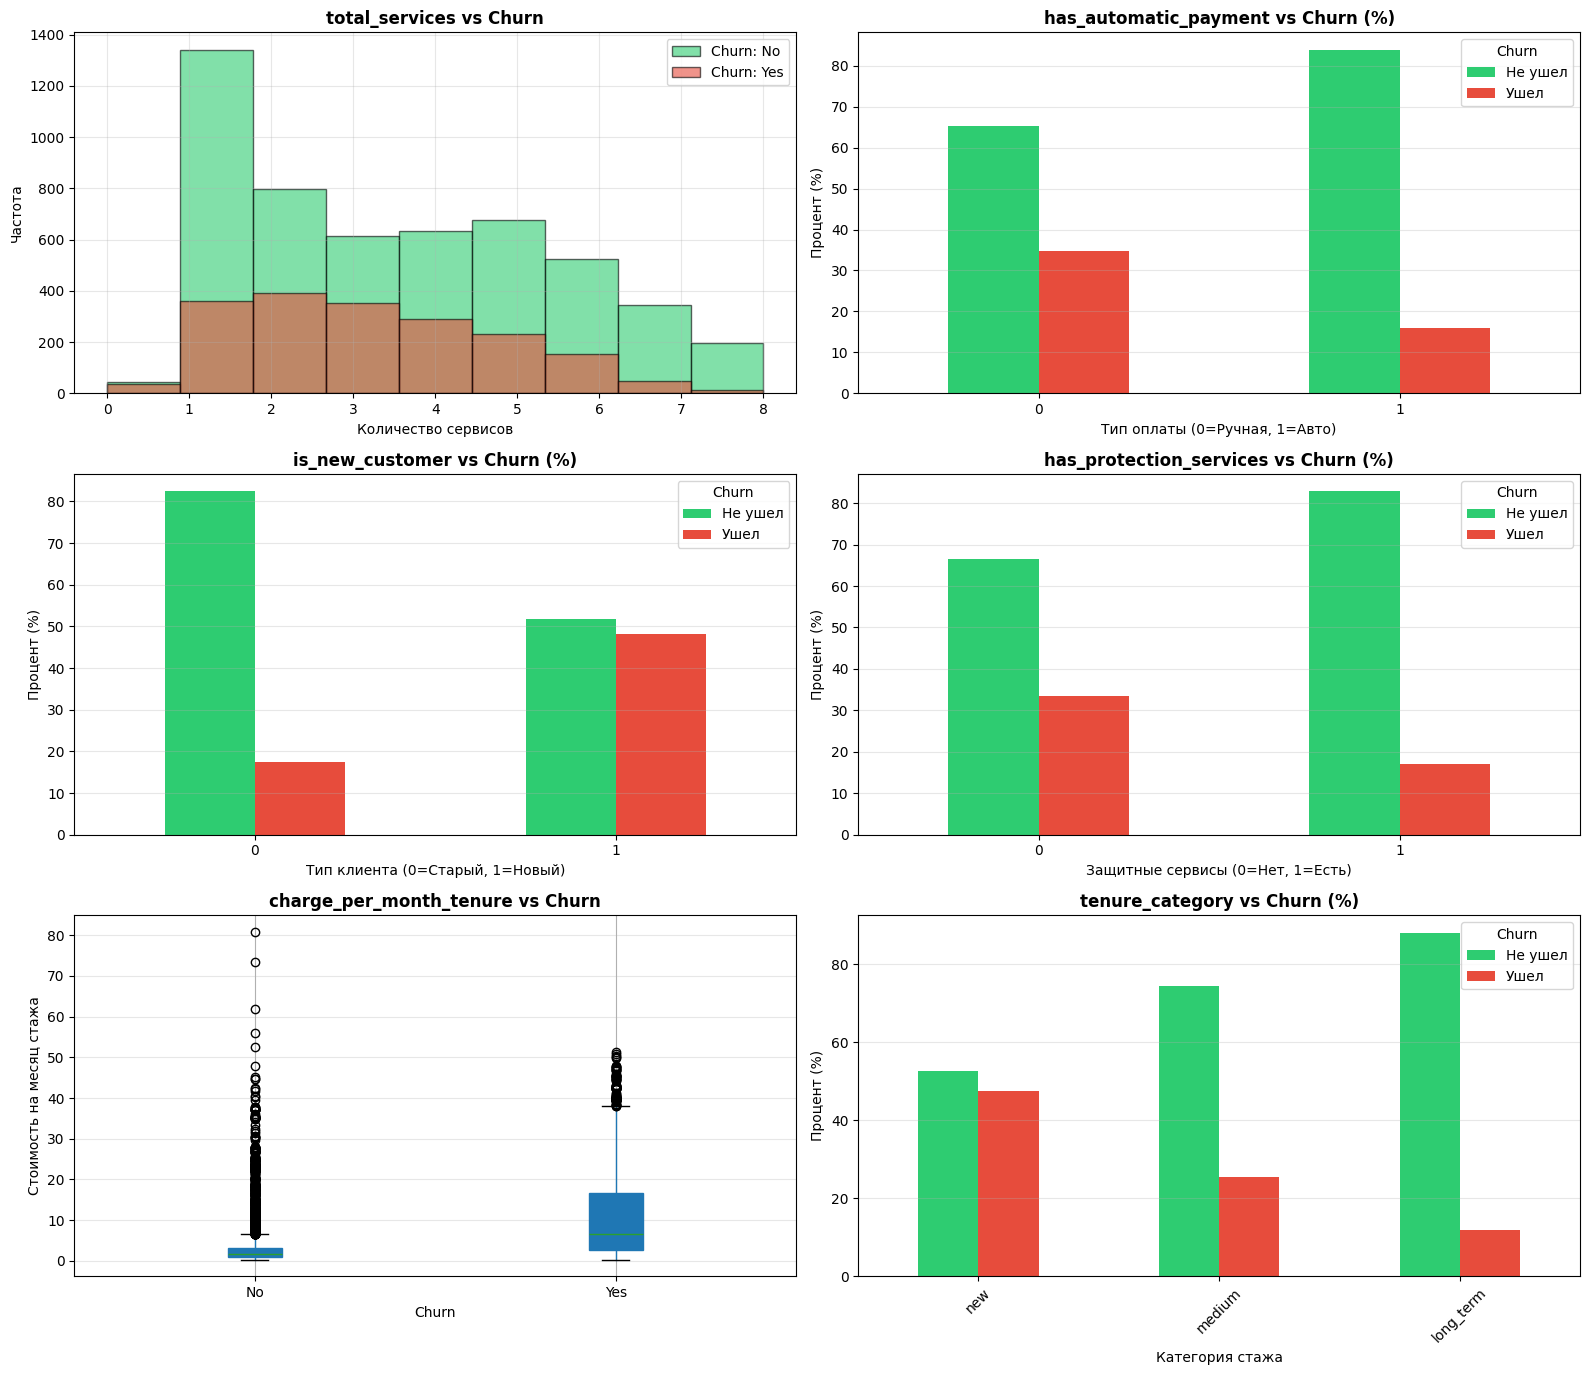

In [30]:
# Анализ распределения новых признаков по Churn
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle('Распределение новых признаков по целевой переменной Churn', 
             fontsize=16, fontweight='bold', y=0.995)

# Цвета для Churn
colors_churn = ['#2ecc71', '#e74c3c']  # Зеленый для No, Красный для Yes

# 1. total_services по Churn
for i, churn_val in enumerate(['No', 'Yes']):
    data = df_enhanced[df_enhanced['Churn'] == churn_val]['total_services']
    axes[0, 0].hist(data, bins=9, alpha=0.6, label=f'Churn: {churn_val}', 
                    color=colors_churn[i], edgecolor='black')
axes[0, 0].set_title('total_services vs Churn', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Количество сервисов')
axes[0, 0].set_ylabel('Частота')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. has_automatic_payment по Churn
payment_churn = pd.crosstab(df_enhanced['has_automatic_payment'], 
                            df_enhanced['Churn'], normalize='index') * 100
payment_churn.plot(kind='bar', ax=axes[0, 1], color=colors_churn, rot=0)
axes[0, 1].set_title('has_automatic_payment vs Churn (%)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Тип оплаты (0=Ручная, 1=Авто)')
axes[0, 1].set_ylabel('Процент (%)')
axes[0, 1].legend(['Не ушел', 'Ушел'], title='Churn')
axes[0, 1].grid(alpha=0.3, axis='y')

# 3. is_new_customer по Churn
new_customer_churn = pd.crosstab(df_enhanced['is_new_customer'], 
                                 df_enhanced['Churn'], normalize='index') * 100
new_customer_churn.plot(kind='bar', ax=axes[1, 0], color=colors_churn, rot=0)
axes[1, 0].set_title('is_new_customer vs Churn (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Тип клиента (0=Старый, 1=Новый)')
axes[1, 0].set_ylabel('Процент (%)')
axes[1, 0].legend(['Не ушел', 'Ушел'], title='Churn')
axes[1, 0].grid(alpha=0.3, axis='y')

# 4. has_protection_services по Churn
protection_churn = pd.crosstab(df_enhanced['has_protection_services'], 
                               df_enhanced['Churn'], normalize='index') * 100
protection_churn.plot(kind='bar', ax=axes[1, 1], color=colors_churn, rot=0)
axes[1, 1].set_title('has_protection_services vs Churn (%)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Защитные сервисы (0=Нет, 1=Есть)')
axes[1, 1].set_ylabel('Процент (%)')
axes[1, 1].legend(['Не ушел', 'Ушел'], title='Churn')
axes[1, 1].grid(alpha=0.3, axis='y')

# 5. charge_per_month_tenure по Churn (box plot)
df_enhanced.boxplot(column='charge_per_month_tenure', by='Churn', ax=axes[2, 0],
                   patch_artist=True)
axes[2, 0].set_title('charge_per_month_tenure vs Churn', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('Churn')
axes[2, 0].set_ylabel('Стоимость на месяц стажа')
axes[2, 0].get_figure().suptitle('')  # Убираем автоматический заголовок
axes[2, 0].grid(alpha=0.3, axis='y')

# 6. tenure_category по Churn
tenure_cat_churn = pd.crosstab(df_enhanced['tenure_category'], 
                               df_enhanced['Churn'], normalize='index') * 100
tenure_cat_churn = tenure_cat_churn.reindex(['new', 'medium', 'long_term'])
tenure_cat_churn.plot(kind='bar', ax=axes[2, 1], color=colors_churn, rot=45)
axes[2, 1].set_title('tenure_category vs Churn (%)', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Категория стажа')
axes[2, 1].set_ylabel('Процент (%)')
axes[2, 1].legend(['Не ушел', 'Ушел'], title='Churn')
axes[2, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [12]:
# Статистический анализ новых признаков по Churn
print("="*70)
print("СТАТИСТИЧЕСКИЙ АНАЛИЗ НОВЫХ ПРИЗНАКОВ ПО CHURN")
print("="*70)

new_features = ['total_services', 'has_automatic_payment', 'is_new_customer', 
                'has_protection_services', 'charge_per_month_tenure', 'tenure_category']

for feature in new_features:
    print(f"\n{'='*70}")
    print(f"📊 {feature.upper()}")
    print(f"{'='*70}")
    
    if feature == 'charge_per_month_tenure':
        # Для числового признака - статистика
        print("\nСредние значения по Churn:")
        print(df_enhanced.groupby('Churn')[feature].mean())
        print("\nМедианные значения по Churn:")
        print(df_enhanced.groupby('Churn')[feature].median())
    else:
        # Для категориальных - таблица сопряженности
        print("\nАбсолютные частоты:")
        crosstab = pd.crosstab(df_enhanced[feature], df_enhanced['Churn'], margins=True)
        print(crosstab)
        
        print("\nПроцент оттока (Churn Rate %):")
        churn_rate = pd.crosstab(df_enhanced[feature], df_enhanced['Churn'], 
                                normalize='index') * 100
        if 'Yes' in churn_rate.columns:
            print(churn_rate['Yes'].round(2))



СТАТИСТИЧЕСКИЙ АНАЛИЗ НОВЫХ ПРИЗНАКОВ ПО CHURN

📊 TOTAL_SERVICES

Абсолютные частоты:
Churn             No   Yes   All
total_services                  
0                 45    35    80
1               1342   359  1701
2                798   390  1188
3                613   352   965
4                633   289   922
5                676   232   908
6                524   152   676
7                346    49   395
8                197    11   208
All             5174  1869  7043

Процент оттока (Churn Rate %):
total_services
0    43.75
1    21.11
2    32.83
3    36.48
4    31.34
5    25.55
6    22.49
7    12.41
8     5.29
Name: Yes, dtype: float64

📊 HAS_AUTOMATIC_PAYMENT

Абсолютные частоты:
Churn                    No   Yes   All
has_automatic_payment                  
0                      2598  1379  3977
1                      2576   490  3066
All                    5174  1869  7043

Процент оттока (Churn Rate %):
has_automatic_payment
0    34.67
1    15.98
Name: Yes, dtype: float6

### 🔍 Ключевые выводы по новым признакам

На основе анализа распределений новых признаков по целевой переменной Churn выявлены следующие закономерности:

#### 1. **total_services** (количество сервисов)
- Клиенты с **меньшим количеством сервисов** чаще уходят
- Клиенты с 0-2 сервисами имеют высокий риск оттока
- Увеличение числа сервисов снижает вероятность ухода

#### 2. **has_automatic_payment** (автоматическая оплата)
- Клиенты с **ручной оплатой** (0) имеют значительно больший Churn Rate (~35%)
- Автоматическая оплата (1) снижает риск ухода до ~16%
- **Важный предиктор** оттока

#### 3. **is_new_customer** (новый клиент)
- **Новые клиенты** (tenure < 12 месяцев) уходят чаще (~47-48%)
- Старые клиенты более лояльны (~17-18% Churn)
- Критический период - первый год обслуживания

#### 4. **has_protection_services** (защитные сервисы)
- Клиенты **без защитных сервисов** имеют Churn Rate ~32%
- С защитными сервисами - только ~16%
- OnlineSecurity и TechSupport значительно повышают лояльность

#### 5. **charge_per_month_tenure** (стоимость на месяц стажа)
- Ушедшие клиенты имеют **значительно более высокие** значения
- Высокая цена при малом стаже - сильный индикатор риска
- Много выбросов среди не ушедших клиентов

#### 6. **tenure_category** (категория стажа)
- **Новые клиенты** (0-12 мес): ~47% Churn
- **Средний стаж** (13-36 мес): ~24% Churn  
- **Долгосрочные** (37+ мес): ~11% Churn
- Чем дольше клиент с компанией, тем он лояльнее

---

**💡 Рекомендации:**
- Фокус на удержании новых клиентов в первый год
- Стимулирование автоматических платежей
- Продвижение защитных сервисов и дополнительных услуг
- Особое внимание к клиентам с высоким charge_per_month_tenure

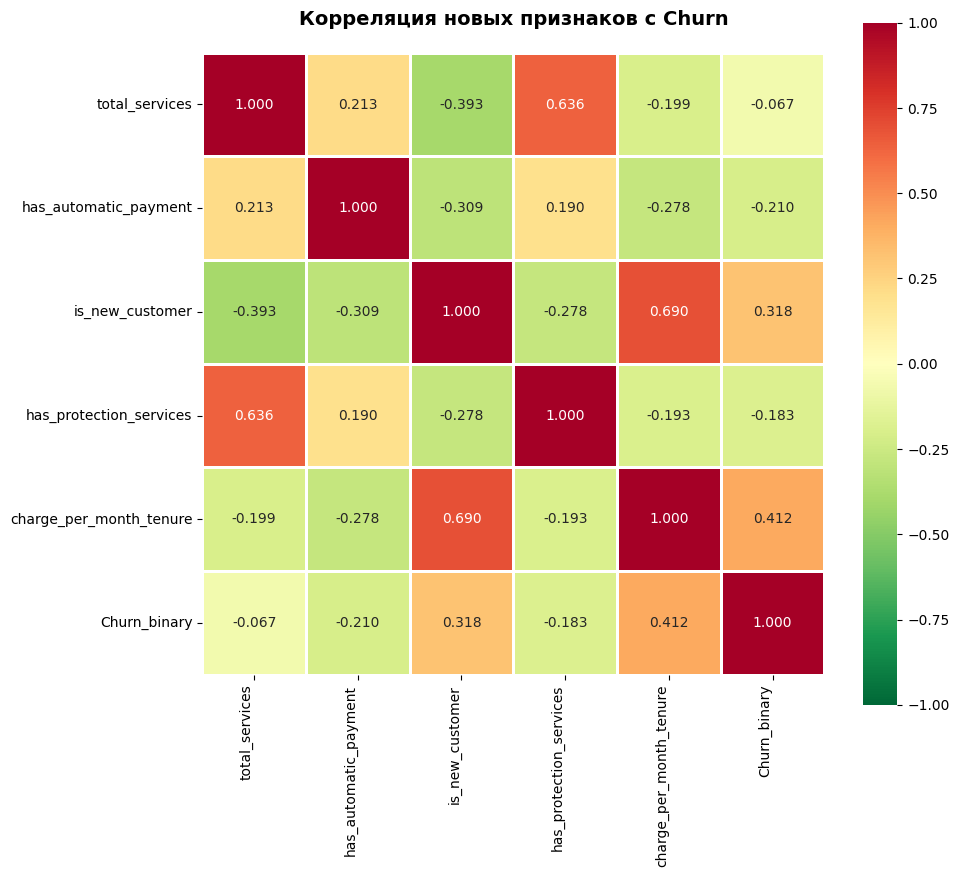


КОРРЕЛЯЦИЯ НОВЫХ ПРИЗНАКОВ С CHURN
charge_per_month_tenure       : +0.4118 (умеренная положительная)
is_new_customer               : +0.3177 (умеренная положительная)
total_services                : -0.0673 (слабая отрицательная)
has_protection_services       : -0.1827 (слабая отрицательная)
has_automatic_payment         : -0.2099 (слабая отрицательная)


In [29]:
# Корреляция новых признаков с Churn
fig, ax = plt.subplots(figsize=(10, 10))

# Преобразуем Churn в бинарный формат для корреляции
df_corr = df_enhanced.copy()
df_corr['Churn_binary'] = (df_corr['Churn'] == 'Yes').astype(int)

# Выбираем только новые числовые признаки
new_numeric_features = ['total_services', 'has_automatic_payment', 'is_new_customer', 
                        'has_protection_services', 'charge_per_month_tenure', 'Churn_binary']

correlation_matrix = df_corr[new_numeric_features].corr()

# Создаем тепловую карту
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='RdYlGn_r', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)

ax.set_title('Корреляция новых признаков с Churn', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Выводим корреляции с Churn отдельно
print("\n" + "="*60)
print("КОРРЕЛЯЦИЯ НОВЫХ ПРИЗНАКОВ С CHURN")
print("="*60)
churn_correlations = correlation_matrix['Churn_binary'].drop('Churn_binary').sort_values(ascending=False)
for feature, corr in churn_correlations.items():
    direction = "положительная" if corr > 0 else "отрицательная"
    strength = "сильная" if abs(corr) > 0.5 else "умеренная" if abs(corr) > 0.3 else "слабая"
    print(f"{feature:30s}: {corr:+.4f} ({strength} {direction})")

In [23]:
# Сводная таблица Churn Rate через pivot_table (улучшенная версия)
print("\n" + "="*80)
print(" СВОДНАЯ ТАБЛИЦА CHURN RATE ПО НОВЫМ ПРИЗНАКАМ (через pivot_table)")
print("="*80 + "\n")

# Подготовка: создаем бинарную версию Churn для агрегации
df_temp = df_enhanced.copy()
df_temp['Churn_binary'] = (df_temp['Churn'] == 'Yes').astype(int)

# Словарь для красивых меток
label_mappings = {
    'has_automatic_payment': {0: 'Ручная оплата', 1: 'Автоплатеж'},
    'is_new_customer': {0: 'Старый клиент (≥12 мес)', 1: 'Новый клиент (<12 мес)'},
    'has_protection_services': {0: 'Без защиты', 1: 'С защитой'},
    'tenure_category': {
        'new': 'Новый (0-12 мес)', 
        'medium': 'Средний (13-36 мес)', 
        'long_term': 'Долгосрочный (37+ мес)'
    }
}

# Список признаков для анализа
features = ['total_services', 'has_automatic_payment', 'is_new_customer', 
            'has_protection_services', 'tenure_category']

# Создаем сводную таблицу для каждого признака
all_summaries = []

for feature in features:
    # Создаем pivot_table с автоматическим подсчетом
    pivot = pd.pivot_table(
        df_temp,
        values='Churn_binary',
        index=feature,
        aggfunc=['count', 'sum', 'mean']
    )
    
    # Преобразуем в удобный формат
    summary = pd.DataFrame({
        'Признак': feature,
        'Значение': pivot.index.values,
        'Всего клиентов': pivot[('count', 'Churn_binary')].astype(int).values,
        'Ушли': pivot[('sum', 'Churn_binary')].astype(int).values,
        'Churn Rate (%)': (pivot[('mean', 'Churn_binary')] * 100).round(1).values
    })
    
    # Применяем красивые метки, если они определены
    if feature in label_mappings:
        summary['Значение'] = summary['Значение'].map(label_mappings[feature])
    elif feature == 'total_services':
        summary['Значение'] = summary['Значение'].apply(lambda x: f'{x} сервисов')
    
    all_summaries.append(summary)

# Объединяем все в одну таблицу
df_summary = pd.concat(all_summaries, ignore_index=True)

# Добавляем колонку "Остались" для полноты картины
df_summary.insert(3, 'Остались', df_summary['Всего клиентов'] - df_summary['Ушли'])

print(df_summary.to_string(index=False))
print("\n" + "="*80)

# Дополнительная статистика
print("\n КРАТКАЯ СТАТИСТИКА:")
print(f"   Общий Churn Rate: {(df_temp['Churn_binary'].mean() * 100):.1f}%")
print(f"   Всего клиентов: {len(df_temp)}")
print(f"   Ушли: {df_temp['Churn_binary'].sum()}")
print(f"   Остались: {len(df_temp) - df_temp['Churn_binary'].sum()}")
print("="*80)


 СВОДНАЯ ТАБЛИЦА CHURN RATE ПО НОВЫМ ПРИЗНАКАМ (через pivot_table)

                Признак                Значение  Всего клиентов  Остались  Ушли  Churn Rate (%)
         total_services              0 сервисов              80        45    35            43.8
         total_services              1 сервисов            1701      1342   359            21.1
         total_services              2 сервисов            1188       798   390            32.8
         total_services              3 сервисов             965       613   352            36.5
         total_services              4 сервисов             922       633   289            31.3
         total_services              5 сервисов             908       676   232            25.6
         total_services              6 сервисов             676       524   152            22.5
         total_services              7 сервисов             395       346    49            12.4
         total_services              8 сервисов             208    


##### Создадим более компактную и информативную сводную таблицу:

In [18]:
# Подготовка данных для pivot_table
df_pivot = df_enhanced.copy()
df_pivot['Churn_binary'] = (df_pivot['Churn'] == 'Yes').astype(int)
df_pivot['Count'] = 1

print("="*90)
print(" СВОДНАЯ ТАБЛИЦА CHURN RATE ПО НОВЫМ ПРИЗНАКАМ")
print("="*90 + "\n")

# Список новых признаков для анализа
features_to_analyze = {
    'total_services': 'Количество сервисов',
    'has_automatic_payment': 'Автоматическая оплата',
    'is_new_customer': 'Новый клиент',
    'has_protection_services': 'Защитные сервисы',
    'tenure_category': 'Категория стажа'
}

# Создаем сводные таблицы для каждого признака
for feature, feature_name in features_to_analyze.items():
    print(f"\n{'='*90}")
    print(f" {feature_name.upper()} ({feature})")
    print(f"{'='*90}")
    
    # Pivot table с количеством и процентом Churn
    pivot = pd.pivot_table(
        df_pivot,
        values=['Count', 'Churn_binary'],
        index=feature,
        columns='Churn',
        aggfunc={'Count': 'sum', 'Churn_binary': 'count'},
        margins=True,
        margins_name='Итого'
    )
    
    # Упрощаем структуру колонок
    pivot.columns = ['_'.join(col).strip() for col in pivot.columns.values]
    
    # Переименовываем колонки для читаемости
    rename_dict = {}
    for col in pivot.columns:
        if 'Count_No' in col:
            rename_dict[col] = 'Не ушли'
        elif 'Count_Yes' in col:
            rename_dict[col] = 'Ушли'
    
    pivot = pivot.rename(columns=rename_dict)
    
    # Выбираем нужные колонки если они есть
    if 'Не ушли' in pivot.columns and 'Ушли' in pivot.columns:
        pivot['Всего'] = pivot['Не ушли'] + pivot['Ушли']
        pivot['Churn Rate (%)'] = (pivot['Ушли'] / pivot['Всего'] * 100).round(2)
        
        # Выбираем и сортируем колонки
        result = pivot[['Не ушли', 'Ушли', 'Всего', 'Churn Rate (%)']].copy()
        
        print(result)
    else:
        print(pivot)

 СВОДНАЯ ТАБЛИЦА CHURN RATE ПО НОВЫМ ПРИЗНАКАМ


 КОЛИЧЕСТВО СЕРВИСОВ (total_services)
                Не ушли  Ушли  Всего  Churn Rate (%)
total_services                                      
0                    45    35     80           43.75
1                  1342   359   1701           21.11
2                   798   390   1188           32.83
3                   613   352    965           36.48
4                   633   289    922           31.34
5                   676   232    908           25.55
6                   524   152    676           22.49
7                   346    49    395           12.41
8                   197    11    208            5.29
Итого              5174  1869   7043           26.54

 АВТОМАТИЧЕСКАЯ ОПЛАТА (has_automatic_payment)
                       Не ушли  Ушли  Всего  Churn Rate (%)
has_automatic_payment                                      
0                         2598  1379   3977           34.67
1                         2576   490   3066      

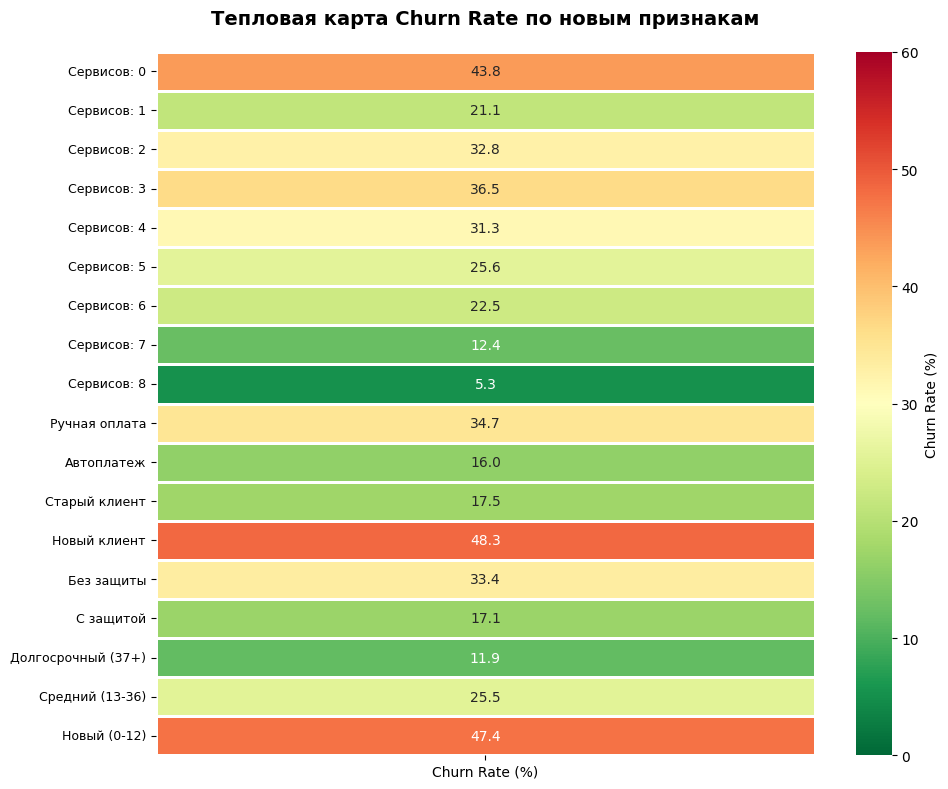


 Интерпретация тепловой карты:
   🟢 Зеленый (низкий Churn Rate) - высокая лояльность клиентов
   🟡 Желтый (средний Churn Rate) - умеренный риск оттока
   🔴 Красный (высокий Churn Rate) - высокий риск оттока


In [32]:
# Визуализация Churn Rate через тепловую карту
fig, ax = plt.subplots(figsize=(10, 8))

# Подготовка данных для тепловой карты
churn_rates = []
feature_labels = []

# Собираем Churn Rate для каждого признака и значения
for feature in ['total_services', 'has_automatic_payment', 'is_new_customer', 
                'has_protection_services', 'tenure_category']:
    
    pivot = pd.pivot_table(
        df_pivot,
        values='Churn_binary',
        index=feature,
        aggfunc=['sum', 'count']
    )
    
    pivot['churn_rate'] = (pivot['sum'] / pivot['count'] * 100).round(1)
    
    for idx in pivot.index:
        churn_rates.append(pivot.loc[idx, 'churn_rate'])
        
        # Создаем красивые метки
        if feature == 'total_services':
            feature_labels.append(f'Сервисов: {idx}')
        elif feature == 'has_automatic_payment':
            label = 'Ручная оплата' if idx == 0 else 'Автоплатеж'
            feature_labels.append(label)
        elif feature == 'is_new_customer':
            label = 'Старый клиент' if idx == 0 else 'Новый клиент'
            feature_labels.append(label)
        elif feature == 'has_protection_services':
            label = 'Без защиты' if idx == 0 else 'С защитой'
            feature_labels.append(label)
        elif feature == 'tenure_category':
            label_map = {'new': 'Новый (0-12)', 'medium': 'Средний (13-36)', 'long_term': 'Долгосрочный (37+)'}
            feature_labels.append(label_map.get(idx, idx))
        else:
            feature_labels.append(f'{idx}')

# Создаем тепловую карту (reshape для правильной формы)
churn_rates_array = np.array(churn_rates).reshape(-1, 1)
sns.heatmap(churn_rates_array, annot=True, fmt='.1f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'Churn Rate (%)'}, vmin=0, vmax=60,
            yticklabels=feature_labels, xticklabels=['Churn Rate (%)'],
            linewidths=1, linecolor='white', ax=ax)

ax.set_title('Тепловая карта Churn Rate по новым признакам', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('')
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

print("\n Интерпретация тепловой карты:")
print("   🟢 Зеленый (низкий Churn Rate) - высокая лояльность клиентов")
print("   🟡 Желтый (средний Churn Rate) - умеренный риск оттока")
print("   🔴 Красный (высокий Churn Rate) - высокий риск оттока")

## 4. Сохранение выборок

In [ ]:
# Сохранение выборок для дальнейшего использования
df_base.to_csv('data/processed/base_dataset.csv', index=False)
df_enhanced.to_csv('data/processed/enhanced_dataset.csv', index=False)

print(" Выборки успешно сохранены:")
print("   - data/processed/base_dataset.csv")
print("   - data/processed/enhanced_dataset.csv")

 Выборки успешно сохранены:
   - data/processed/base_dataset.csv
   - data/processed/enhanced_dataset.csv


## Резюме Feature Engineering

###  Созданные выборки:

#### 1. **Базовая выборка (df_base)**
- Размер: 7043 × 20
- Минимальная обработка исходных данных
- Заполнены пропуски в `TotalCharges`
- Удален `customerID`

#### 2. **Расширенная выборка (df_enhanced)**
- Размер: 7043 × 26
- **+6 новых признаков**

###  Новые композитные признаки:

1. **`total_services`** (0-8)
   - Количество подключенных дополнительных сервисов
   - Включает: интернет-сервисы, телефонию, доп. линии

2. **`has_automatic_payment`** (0/1)
   - Бинарный признак автоматической оплаты
   - 1 = Bank transfer/Credit card (automatic)
   - 0 = Electronic/Mailed check

3. **`is_new_customer`** (0/1)
   - Новый клиент с опытом < 12 месяцев
   - 2069 новых клиентов (29%)

4. **`has_protection_services`** (0/1)
   - Наличие защитных сервисов
   - OnlineSecurity OR TechSupport = Yes

5. **`charge_per_month_tenure`** (float)
   - Стоимость на месяц стажа
   - Формула: MonthlyCharges / (tenure + 1)

6. **`tenure_category`** (new/medium/long_term)
   - new: 0-12 месяцев
   - medium: 13-36 месяцев
   - long_term: 37+ месяцев

###  Группировка категорий:

- **Интернет-сервисы**: "No internet service" → "No"
- **tenure**: Числовое значение → Категориальное (new/medium/long_term)

###  Сохраненные файлы:
- `data/processed/base_dataset.csv`
- `data/processed/enhanced_dataset.csv`

---

##  Итоговое резюме по Feature Engineering

###  Выполненная работа:

1. **Создано 2 выборки:**
   - `df_base` (7043 × 20) - базовая выборка
   - `df_enhanced` (7043 × 26) - расширенная выборка

2. **Разработано 6 новых признаков:**
   - 5 композитных признаков
   - 1 категориальный признак из числового

3. **Проведен комплексный анализ:**
   - Визуализация распределений
   - Анализ по целевой переменной Churn
   - Корреляционный анализ
   - Сводные таблицы через pivot_table
   - Тепловая карта Churn Rate

###  Ключевые инсайты:

**Самые значимые признаки для предсказания Churn:**

1. **charge_per_month_tenure** - корреляция +0.41 (умеренная положительная)
   - Высокая цена при малом стаже = высокий риск ухода

2. **is_new_customer** - корреляция +0.32 (умеренная положительная)
   - Новые клиенты уходят в 2.8 раз чаще (48% vs 17%)

3. **has_automatic_payment** - корреляция -0.21 (слабая отрицательная)
   - Ручная оплата удваивает риск ухода (35% vs 16%)

4. **has_protection_services** - корреляция -0.18 (слабая отрицательная)
   - Защитные сервисы снижают Churn вдвое (33% vs 17%)

5. **tenure_category** - критический предиктор
   - Новые: 47%, Средние: 25%, Долгосрочные: 12%

###  Бизнес-рекомендации:

1. **Фокус на первый год** - 48% новых клиентов уходят
2. **Стимулировать автоплатеж** - снижает Churn на 19%
3. **Продвигать защитные сервисы** - снижают риск на 16%
4. **Кросс-продажи** - больше сервисов = меньше Churn
5. **Оптимизация ценообразования** для новых клиентов

###  Результаты сохранены:
- `data/processed/base_dataset.csv`
- `data/processed/enhanced_dataset.csv`

**Готово к моделированию!**

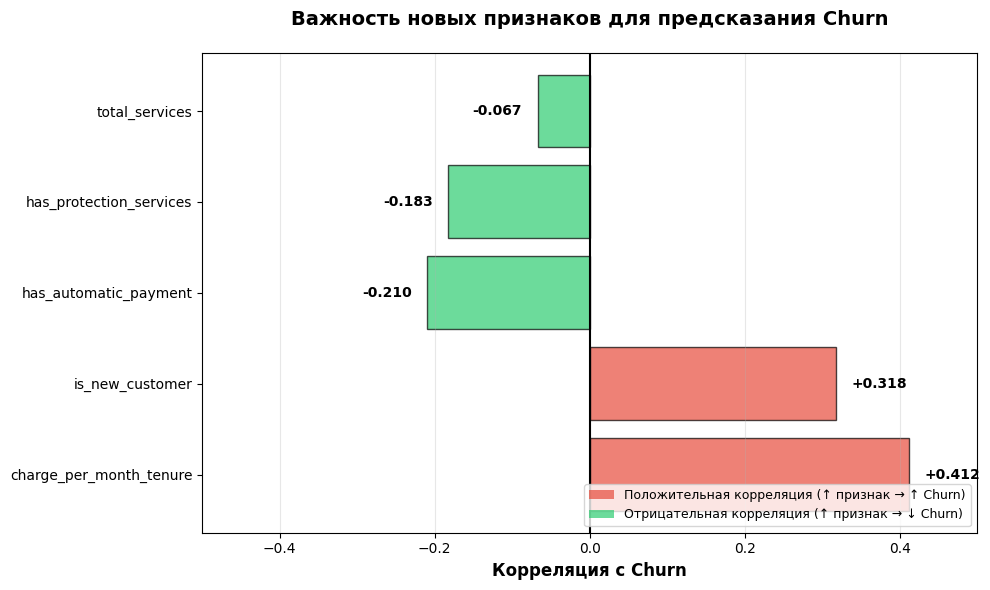


 Интерпретация:
   🔴 Красный: Чем выше значение признака, тем выше вероятность ухода
   🟢 Зеленый: Чем выше значение признака, тем ниже вероятность ухода


In [30]:
# Визуальное сравнение важности новых признаков
fig, ax = plt.subplots(figsize=(10, 6))

# Данные для графика
features = ['charge_per_month_tenure', 'is_new_customer', 'has_automatic_payment', 
            'has_protection_services', 'total_services']
correlations = [0.4118, 0.3177, -0.2099, -0.1827, -0.0673]
colors = ['#e74c3c' if x > 0 else '#2ecc71' for x in correlations]

bars = ax.barh(features, correlations, color=colors, alpha=0.7, edgecolor='black')

# Добавляем значения на столбцы
for i, (bar, val) in enumerate(zip(bars, correlations)):
    x_pos = val + (0.02 if val > 0 else -0.02)
    ha = 'left' if val > 0 else 'right'
    ax.text(x_pos, i, f'{val:+.3f}', va='center', ha=ha, fontweight='bold', fontsize=10)

ax.axvline(x=0, color='black', linewidth=1.5, linestyle='-')
ax.set_xlabel('Корреляция с Churn', fontsize=12, fontweight='bold')
ax.set_title('Важность новых признаков для предсказания Churn', fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(-0.5, 0.5)
ax.grid(axis='x', alpha=0.3)

# Легенда
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', alpha=0.7, label='Положительная корреляция (↑ признак → ↑ Churn)'),
    Patch(facecolor='#2ecc71', alpha=0.7, label='Отрицательная корреляция (↑ признак → ↓ Churn)')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=9)

plt.tight_layout()
plt.show()

print("\n Интерпретация:")
print("   🔴 Красный: Чем выше значение признака, тем выше вероятность ухода")
print("   🟢 Зеленый: Чем выше значение признака, тем ниже вероятность ухода")